In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import scipy.misc

## STO model, calcualte the bond length between Sr-Sr and Sr-Ti

In [126]:
# Load the distance data calculated in Igor in unit of pixel.
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
file = sio.loadmat(path + 'DenoiseOutput_fullsize/STO/BondLength_1000FPS.mat')
Sr_Sr_noisy = file['Sr_Sr_noisy']*17.8
Sr_Ti_noisy = file['Sr_Ti_noisy']*17.8
Sr_Sr_denoised = file['Sr_Sr_denoised']*17.8
Sr_Ti_denoised = file['Sr_Ti_denoised']*17.8
noisy = np.concatenate((Sr_Sr_noisy,Sr_Ti_noisy),axis=0)
denoised = np.concatenate((Sr_Sr_denoised,Sr_Ti_denoised),axis=0)
# noisy = Sr_Ti_noisy
# denoised = Sr_Ti_denoised

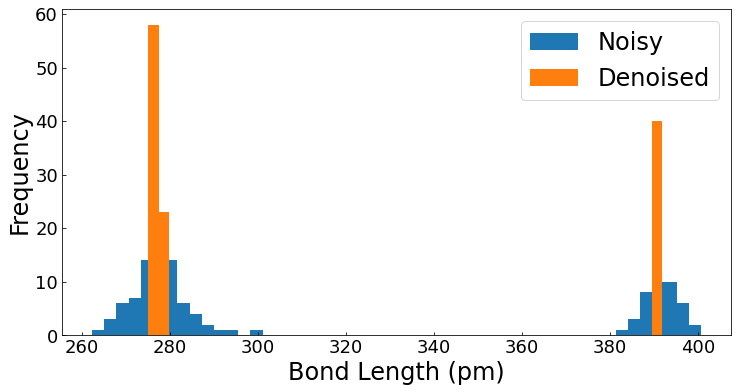

In [130]:
# A single histogram showing the Sr-Sr and Sr-Ti bond length
# bins = np.arange(240, 310, 3)

plt.figure(figsize=(12,6))
ax = plt.subplot(111)
# plt.hist(noisy, bins=bins,label='Noisy')
# plt.hist(denoised, bins=bins, label = 'Denoised')
plt.hist(noisy,bins=50,label='Noisy')
plt.hist(denoised,bins=50,label = 'Denoised')
plt.xlabel('Bond Length (pm)',fontsize = 24)
plt.xticks(fontsize=18)
plt.ylabel('Frequency', fontsize = 24)
plt.yticks(fontsize=18)
ax.tick_params(direction='in')
plt.legend(fontsize=24)
plt.show()

In [79]:
# Analyze the standard deviation under different noise levels
FPS_list = [1000,2000,4000,6000,8000,10000]
std_list = np.zeros((4,len(FPS_list))) # list for standrad deviations in pm, Sr-Sr noisy, Sr-Sr denoised, Sr-Ti noisy, Sr-Ti denoised
for iFPS in range(len(FPS_list)):
    FPS = FPS_list[iFPS]
    print(FPS)
    file = sio.loadmat(path + 'DenoiseOutput_fullsize/STO/BondLength_'+str(FPS)+'FPS.mat')
    Sr_Sr_noisy = file['Sr_Sr_noisy']*17.8
    Sr_Ti_noisy = file['Sr_Ti_noisy']*17.8
    Sr_Sr_denoised = file['Sr_Sr_denoised']*17.8
    Sr_Ti_denoised = file['Sr_Ti_denoised']*17.8
    std_list[0,iFPS] = np.std(Sr_Sr_noisy)
    std_list[1,iFPS] = np.std(Sr_Sr_denoised)
    std_list[2,iFPS] = np.std(Sr_Ti_noisy)
    std_list[3,iFPS] = np.std(Sr_Ti_denoised)
    
print(std_list)

1000
2000
4000
6000
8000
10000
[[ 3.97350532 10.1956896  10.12078912 19.14645259 23.12508466 24.7306879 ]
 [ 0.09036019  0.20346096  0.20346096  0.11900214  0.06565869  0.15561584]
 [ 6.21163249 11.66125713 17.72020444 23.11221245 25.2185488  30.29796053]
 [ 1.10307364  1.6939218   1.93015629  1.61932855  0.48369029  6.15928267]]


Text(0, 0.5, 'Precision (pm)')

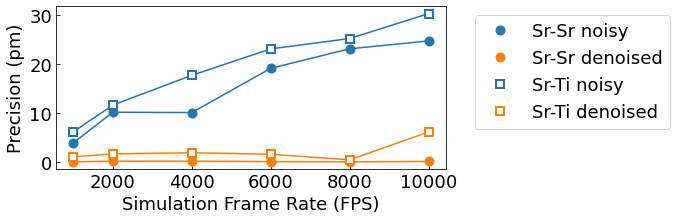

In [112]:
# Plot the standard deviation results
# When plotting, blue color for noisy data, orange color for denoised data, same will be used for Si data
# filled scatters for Sr-Sr, empty scatters for Sr-Ti
plt.figure(figsize=(7,3))
ax = plt.subplot(111)

# Sr-Sr bond length standard deviation (precision), filled points
ax.plot(FPS_list,std_list[0,:],color='#1f77b4')
ax.plot(FPS_list,std_list[0,:], 'o', markersize=8, mfc='#1f77b4', mew=2,label='Sr-Sr noisy')
ax.plot(FPS_list,std_list[1,:],color='#ff7f0e')
ax.plot(FPS_list,std_list[1,:], 'o', markersize=8, mfc='#ff7f0e', mew=2, mec='#ff7f0e',label='Sr-Sr denoised')

# Sr-Ti bond length standard deviation, empty points
ax.plot(FPS_list,std_list[2,:],color='#1f77b4')
ax.plot(FPS_list,std_list[2,:], 's', markersize=8, mfc='white', mew=2, mec='#1f77b4',label='Sr-Ti noisy')
ax.plot(FPS_list,std_list[3,:],color='#ff7f0e')
ax.plot(FPS_list,std_list[3,:], 's', markersize=8, mfc='white', mew=2, mec='#ff7f0e',label='Sr-Ti denoised')

# overall setting, axis labels, and legend
ax.legend(fontsize=18,bbox_to_anchor=(1.05,1))
ax.tick_params(direction='in',labelsize=18)
plt.xlabel('Simulation Frame Rate (FPS)',fontsize=18)
plt.ylabel('Precision (pm)',fontsize=18)

## Si edge dislocation model, calculate the displacement from truth

In [5]:
# path to raw data, denoised data, and ground truth
# no data exceeds 2GB thus they are all saved in .mat or .py
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
raw_data = sio.loadmat(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

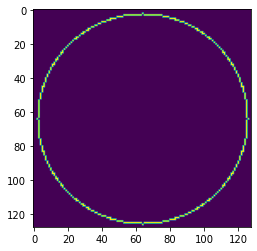

In [6]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoised_data[:,:,i*128+j]
            ADF_truth = ADF_truth + truth_data[:,:,i*128+j]

(-0.5, 113.5, 113.5, -0.5)

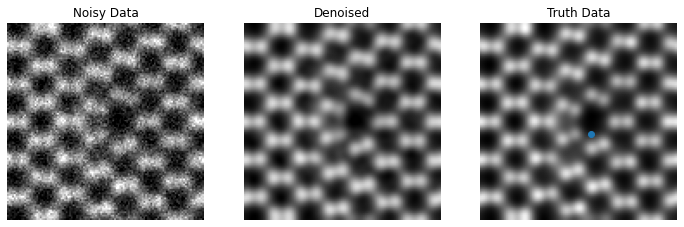

In [7]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(132)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high],cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high],cmap='gray')
plt.title('Noisy Data')
plt.axis('off')
# plt.colorbar()

plt.subplot(133)
plt.imshow(ADF_truth,clim=[clim_low,clim_high],cmap='gray')
plt.title('Truth Data')
plt.scatter(64,64)
plt.axis('off')
# plt.colorbar()

In [ ]:
mdic = {"noisy": ADF_noisy, "denoised": ADF_denoised}
sio.savemat(path + 'DenoiseOutput_fullsize/SiDislocation/ADFimage_6000FPS.mat', mdic)

In [174]:
scipy.misc.imsave('noisy.tiff', ADF_noisy)
scipy.misc.imsave('denoised.tiff', ADF_denoised)
scipy.misc.imsave('truth.tiff', ADF_truth)

C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Fit all the Si positions on Silicon using Igor
The fitting of the Si dumbbells need to fit each dumbbell to a sum of two Gaussian functions. So far, I don't have a good way to do it in Python.
<br>The fitting of the atom positions around the dislocation core could be hard, as the peak shapes are not very round in the denoised image or noisy data. It seems fitting window with 16px-by-8px size with initial peak position set to (center_x +/- 3px, center_y) for 1000-40000 FPS data.
<br>The only exception is for denoised 1000FPS data, 16px by 10px size box used.

## Load the fitted Si positions
<br>Under each set of AtomPositions.mat file, there is a total three variables saving the fitted atom positions of noisy image, denoised image, and ground truth.
Within each variable, the first column contains the x coordinates and the second column contains the y coordinates.

In [131]:
# Test using one single dataset
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
atom_positions = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/AtomPositions_1000FPS.mat')
noisy_positions = atom_positions['Si_noisy']
denoised_positions = atom_positions['Si_denoised']
truth_positions = atom_positions['Si_truth']

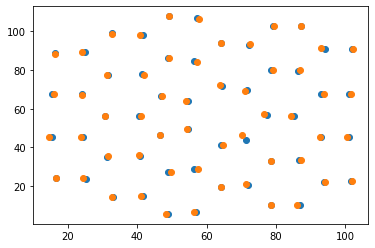

In [132]:
diff_noisy = noisy_positions - truth_positions
# diff_noisy = np.sqrt(diff_noisy[:,0]**2 + diff_noisy[:,1]**2)
diff_denoised = denoised_positions - truth_positions
# diff_denoised = np.sqrt(diff_denoised[:,0]**2 + diff_denoised[:,1]**2)
plt.scatter(truth_positions[:,0],truth_positions[:,1])
# plt.scatter(denoised_positions[:,0],denoised_positions[:,1])
plt.scatter(noisy_positions[:,0],noisy_positions[:,1])

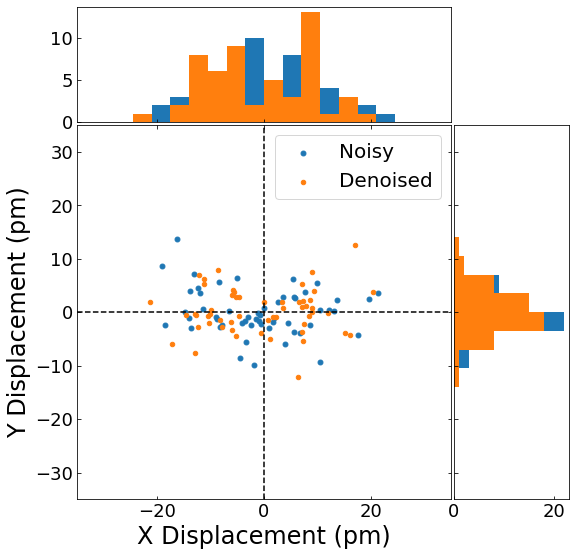

In [133]:
# Scatter plot with histogram to show the denoising improvment
# Convert unit from px to pm
diff_noisy_pm = diff_noisy * 17.5
diff_denoised_pm = diff_denoised * 17.5

x, y = diff_noisy_pm[1:-1,0].flatten(), diff_noisy_pm[1:-1,1].flatten()

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y,s=24,color='#1f77b4', label='Noisy')
ax_scatter.set_xlabel('Movement X (px)',fontsize=22)
ax_scatter.set_ylabel('Movement Y (px)',fontsize=22)
ax_scatter.tick_params(direction='in',labelsize = 18)

# now determine nice limits by hand:
binwidth = 0.2 * 17.5
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
lim = 2 * 17.5
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
ax_scatter.axhline(y=0, linestyle='dashed', color='black')
ax_scatter.axvline(x=0, linestyle='dashed', color='black')

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')
ax_histx.tick_params(labelsize=18)
ax_histy.tick_params(labelsize=18)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

# Plot the denoised part

x, y = diff_denoised_pm[1:-1,0].flatten(), diff_denoised_pm[1:-1,1].flatten()

ax_scatter.scatter(x, y,s=20,color='#ff7f0e', label='Denoised')
ax_scatter.set_xlabel('X Displacement (pm)',fontsize=24)
ax_scatter.set_ylabel('Y Displacement (pm)',fontsize=24)
ax_scatter.tick_params(direction='in',labelsize = 18)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')
ax_scatter.legend(fontsize=20)

plt.show()

In [104]:
# Quantify the displacment for different frame rates
FPS_list = [1000,2000,4000,6000,8000,10000]
rmse_list = np.zeros((2,len(FPS_list)))
for iFPS in range(len(FPS_list)):
    FPS = FPS_list[iFPS]
    atom_positions = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/AtomPositions_'+str(FPS)+'FPS.mat')
    noisy_positions = atom_positions['Si_noisy']
    denoised_positions = atom_positions['Si_denoised']
    truth_positions = atom_positions['Si_truth']
    diff_noisy = noisy_positions - truth_positions
    diff_noisy = np.sqrt(diff_noisy[:,0]**2 + diff_noisy[:,1]**2)
    diff_denoised = denoised_positions - truth_positions
    diff_denoised = np.sqrt(diff_denoised[:,0]**2 + diff_denoised[:,1]**2)
    rmse_list[0,iFPS] = np.mean(diff_noisy[diff_noisy<5])
    rmse_list[1,iFPS] = np.mean(diff_denoised[diff_denoised<5])

(3.0, 30.0)

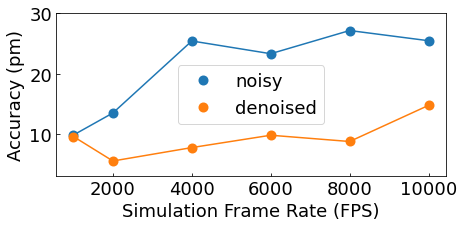

In [113]:
# The fitting result from 2000 FPS is more accurate than the result from 1000FPS for some unknown reason
plt.figure(figsize=(7,3))
ax = plt.subplot(111)

ax.plot(FPS_list,rmse_list[0,:]*17.5,color='#1f77b4')
ax.plot(FPS_list,rmse_list[0,:]*17.5, 'o', markersize=8, mfc='#1f77b4', mew=2,label='noisy')
ax.plot(FPS_list,rmse_list[1,:]*17.5,color='#ff7f0e')
ax.plot(FPS_list,rmse_list[1,:]*17.5, 'o', markersize=8, mfc='#ff7f0e', mew=2, mec='#ff7f0e',label='denoised')

# overall setting, axis labels, and legend
ax.legend(fontsize=18)
ax.tick_params(direction='in',labelsize=18)
plt.xlabel('Simulation Frame Rate (FPS)',fontsize=18)
plt.ylabel('Accuracy (pm)',fontsize=18)
plt.ylim([3,30])

## Functions that will be called

In [2]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [3]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [4]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()